<a href="https://colab.research.google.com/github/umendra/aiml-experiments/blob/main/04_transfer_learning_feature_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Get data (10% of labels)
import zipfile

# Download data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip", "r")
zip_ref.extractall()
zip_ref.close()

--2022-10-25 10:30:40--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.141.128, 173.194.210.128, 173.194.211.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.141.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  53.6MB/s    in 3.0s    

2022-10-25 10:30:43 (53.6 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



# New Section

In [ ]:
!ls drive/MyDrive/Colab\ Notebooks/data/images

10_food_classes_all_data  food-101  pizza_steak  test_pizza_steak


In [ ]:
!mv 10_food_classes_10_percent drive/MyDrive/Colab\ Notebooks/data/images

In [2]:
# How many images in each folder?
import os

# Walk through 10 percent data directory and list number of files
ImageRootDir = "drive/MyDrive/Colab Notebooks/data/images/10_food_classes_10_percent"
for dirpath, dirnames, filenames in os.walk(ImageRootDir):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in 'drive/MyDrive/Colab Notebooks/data/images/10_food_classes_10_percent'.
There are 10 directories and 0 images in 'drive/MyDrive/Colab Notebooks/data/images/10_food_classes_10_percent/train'.
There are 0 directories and 75 images in 'drive/MyDrive/Colab Notebooks/data/images/10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in 'drive/MyDrive/Colab Notebooks/data/images/10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in 'drive/MyDrive/Colab Notebooks/data/images/10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in 'drive/MyDrive/Colab Notebooks/data/images/10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in 'drive/MyDrive/Colab Notebooks/data/images/10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in 'drive/MyDrive/Colab Notebooks/data/images/10_food_classes_10_percent/train/hamburger'.
The

## Prepare Data - Load data from directory
Setup data loader

In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32
train_data_dir = os.path.join(ImageRootDir, "train")
test_data_dir = os.path.join(ImageRootDir, "test")
print(train_data_dir, test_data_dir)

drive/MyDrive/Colab Notebooks/data/images/10_food_classes_10_percent/train drive/MyDrive/Colab Notebooks/data/images/10_food_classes_10_percent/test


In [5]:
# Instantiate data generator. Provide rescale to make data in [0,1]
train_data_gen = ImageDataGenerator(rescale=1/255)
test_data_gen = ImageDataGenerator(rescale=1/255)

# Load train and test data
print("Loading training data ...")
train_data = train_data_gen.flow_from_directory(
    train_data_dir,
    target_size=IMAGE_SHAPE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

print('Loading test data ...')
test_data = test_data_gen.flow_from_directory(
    test_data_dir,
    target_size=IMAGE_SHAPE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Loading training data ...
Found 750 images belonging to 10 classes.
Loading test data ...
Found 2500 images belonging to 10 classes.


## Add callbacks

In [6]:
# Create tensorboard callback
import datetime as dt

def create_tensorboard_callback(dirname, experiment_name):
  log_dir = dirname + "/" + experiment_name + "/" + dt.datetime.now().strftime('%Y%m%d-%H%M%S')
  tensorboard_cb = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving TensorBoard logs to {log_dir}")
  return tensorboard_cb


# Use tensorhub to load pretrained models

We will use pretrained models to make most of our models.

In [7]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [8]:
# URL of pre trained models
resnet_v1_url = "https://tfhub.dev/google/imagenet/resnet_v1_101/feature_vector/5"
efficient_model_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [9]:
# helper function to create a wrapper model for our learning
def create_model(base_url, num_classes=10):
  """Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.
  
  Args:
    base_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in output layer,
      should be equal to number of target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model with base_url as feature
    extractor layer and Dense output layer with num_classes outputs.
  """
  # download the base model and use as feature extraction layer
  feature_extraction_layer = hub.KerasLayer(
      base_url,
      trainable=False,
      name="feature_extraction_layer",
      input_shape=IMAGE_SHAPE + (3,)
  )

  # Create our own model that uses above layer and an output layer
  model = tf.keras.models.Sequential([
      feature_extraction_layer,         # base of our model
      layers.Dense(num_classes, activation='softmax', name='output_layer')
  ])

  return model

## Create ResNet pretrained models

Now that we have helper function, lets begin wih ResNet model. Build the model, compile and fit

In [10]:
resnet_model = create_model(resnet_v1_url, train_data.num_classes)
resnet_model.compile(optimizer=tf.keras.optimizers.Adam(),
                     loss='categorical_crossentropy',
                     metrics='accuracy')

In [11]:
# train the model
resnet_history = resnet_model.fit(train_data,
                                  epochs=5,
                                  validation_data=test_data,
                                  callbacks=[create_tensorboard_callback("tensorboard_hub", "renet50-v1")]
                                  )

Saving TensorBoard logs to tensorboard_hub/renet50-v1/20221201-084914
Epoch 1/5
24/24 [==============================] - 867s 37s/step - loss: 2.0382 - accuracy: 0.3493 - val_loss: 1.2395 - val_accuracy: 0.5984
Epoch 2/5
24/24 [==============================] - 21s 898ms/step - loss: 0.8915 - accuracy: 0.7107 - val_loss: 0.8594 - val_accuracy: 0.7040
Epoch 3/5
24/24 [==============================] - 21s 890ms/step - loss: 0.6138 - accuracy: 0.8067 - val_loss: 0.7643 - val_accuracy: 0.7472
Epoch 4/5
24/24 [==============================] - 21s 890ms/step - loss: 0.4456 - accuracy: 0.8773 - val_loss: 0.6913 - val_accuracy: 0.7696
Epoch 5/5
24/24 [==============================] - 21s 889ms/step - loss: 0.3499 - accuracy: 0.9200 - val_loss: 0.6690 - val_accuracy: 0.7772


In [13]:
# If you wanted to, you could really turn this into a helper function to load in with a helper.py script...
import matplotlib.pyplot as plt

# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

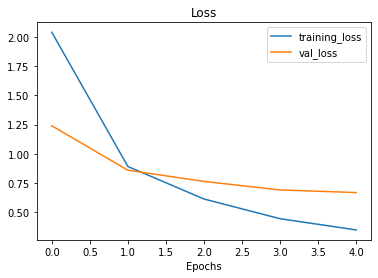

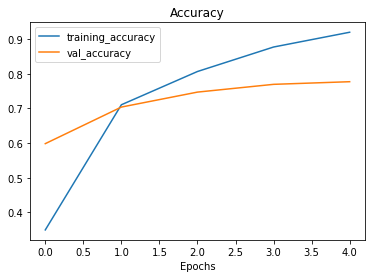

In [14]:
plot_loss_curves(resnet_history)

In [23]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             42605504  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 42,625,994
Trainable params: 20,490
Non-trainable params: 42,605,504
_________________________________________________________________


## Create pretrained Efficient model

In [17]:
effnet_model = create_model(efficient_model_url, train_data.num_classes)
effnet_model.compile(optimizer=tf.keras.optimizers.Adam(),
                     loss='categorical_crossentropy',
                     metrics='accuracy')

In [21]:
# fit the model
# train the model
efnet_history = effnet_model.fit(train_data,
                                  epochs=5,
                                  validation_data=test_data,
                                  callbacks=[create_tensorboard_callback("tensorboard_hub", "efficientnet-b0")]
                                  )

Saving TensorBoard logs to tensorboard_hub/efficientnet-b0/20221201-093805
Epoch 1/5
24/24 [==============================] - 30s 930ms/step - loss: 1.7826 - accuracy: 0.4867 - val_loss: 1.2523 - val_accuracy: 0.7488
Epoch 2/5
24/24 [==============================] - 19s 811ms/step - loss: 1.0384 - accuracy: 0.7667 - val_loss: 0.8491 - val_accuracy: 0.8276
Epoch 3/5
24/24 [==============================] - 19s 818ms/step - loss: 0.7477 - accuracy: 0.8347 - val_loss: 0.6848 - val_accuracy: 0.8500
Epoch 4/5
24/24 [==============================] - 19s 824ms/step - loss: 0.6008 - accuracy: 0.8640 - val_loss: 0.6019 - val_accuracy: 0.8608
Epoch 5/5
24/24 [==============================] - 19s 830ms/step - loss: 0.5099 - accuracy: 0.8800 - val_loss: 0.5481 - val_accuracy: 0.8676


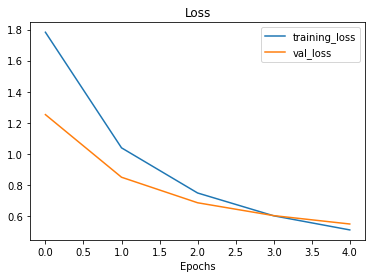

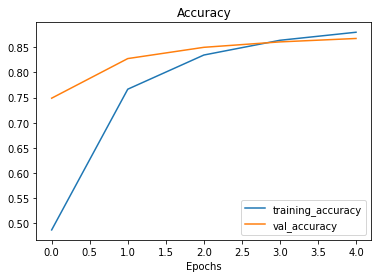

In [22]:
plot_loss_curves(efnet_history)

In [24]:
effnet_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [25]:
# Upload tensorboard data to tensorboard
!tensorboard dev upload --logdir ./tensorboard_hub --name "EfficientNetB0 vs ResNet v1" --description "Comparing two pretrained models" --one_shot


***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorboard_hub

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&state=3OOf5Ucd3oMASNzLeAlb0Clb5hPQ4q&prompt=consent&access_type=off

In [27]:
!tensorboard dev list

https://tensorboard.dev/experiment/PC78gprvT0qkNdeC0UJL1Q/
	Name                 EfficientNetB0 vs ResNet v1
	Description          Comparing two pretrained models
	Id                   PC78gprvT0qkNdeC0UJL1Q
	Created              2022-12-01 09:46:58 (3 minutes ago)
	Updated              2022-12-01 09:47:00 (3 minutes ago)
	Runs                 4
	Tags                 5
	Scalars              60
	Tensor bytes         0
	Binary object bytes  7498153
Total: 1 experiment(s)


In [30]:
!tensorboard dev delete --experiment_id PC78gprvT0qkNdeC0UJL1Q

Deleted experiment PC78gprvT0qkNdeC0UJL1Q.
